# Installation

In [2]:
%pip install -qU pandas matplotlib seaborn scikit-learn lightgbm holidays dask[dataframe] tqdm h2o polars pyarrow

Note: you may need to restart the kernel to use updated packages.


# Data preparation

In [1]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/validation.csv")

Preparation of weight and distance for train dataset:



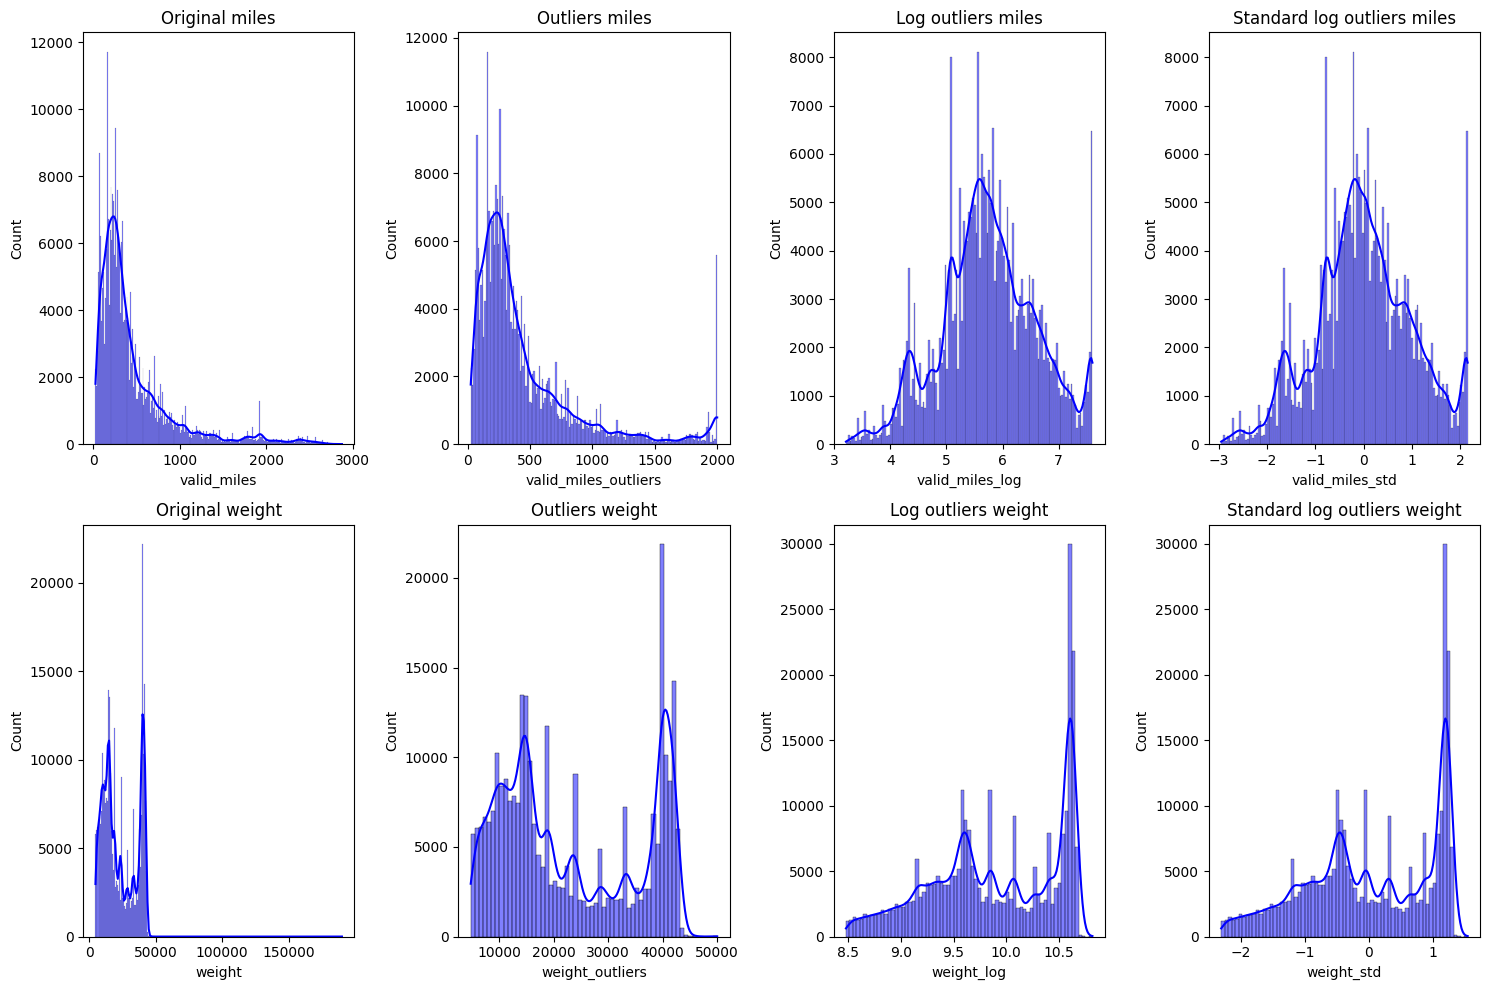

Preparation of weight and distance for validation dataset:



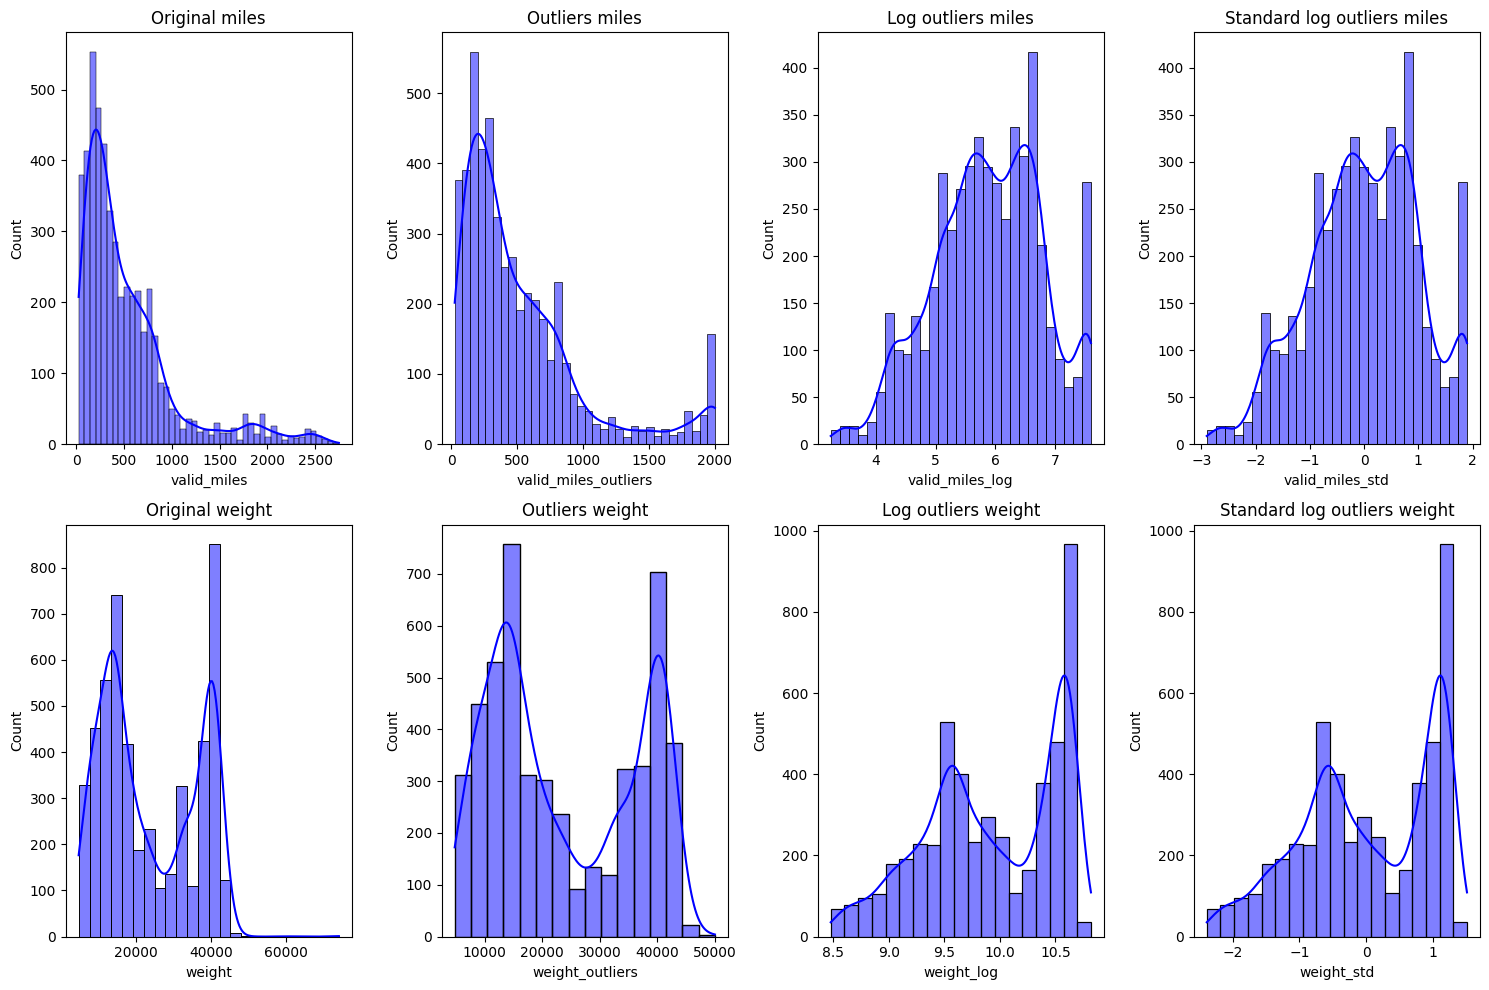

Preparation of weight and distance for test dataset:



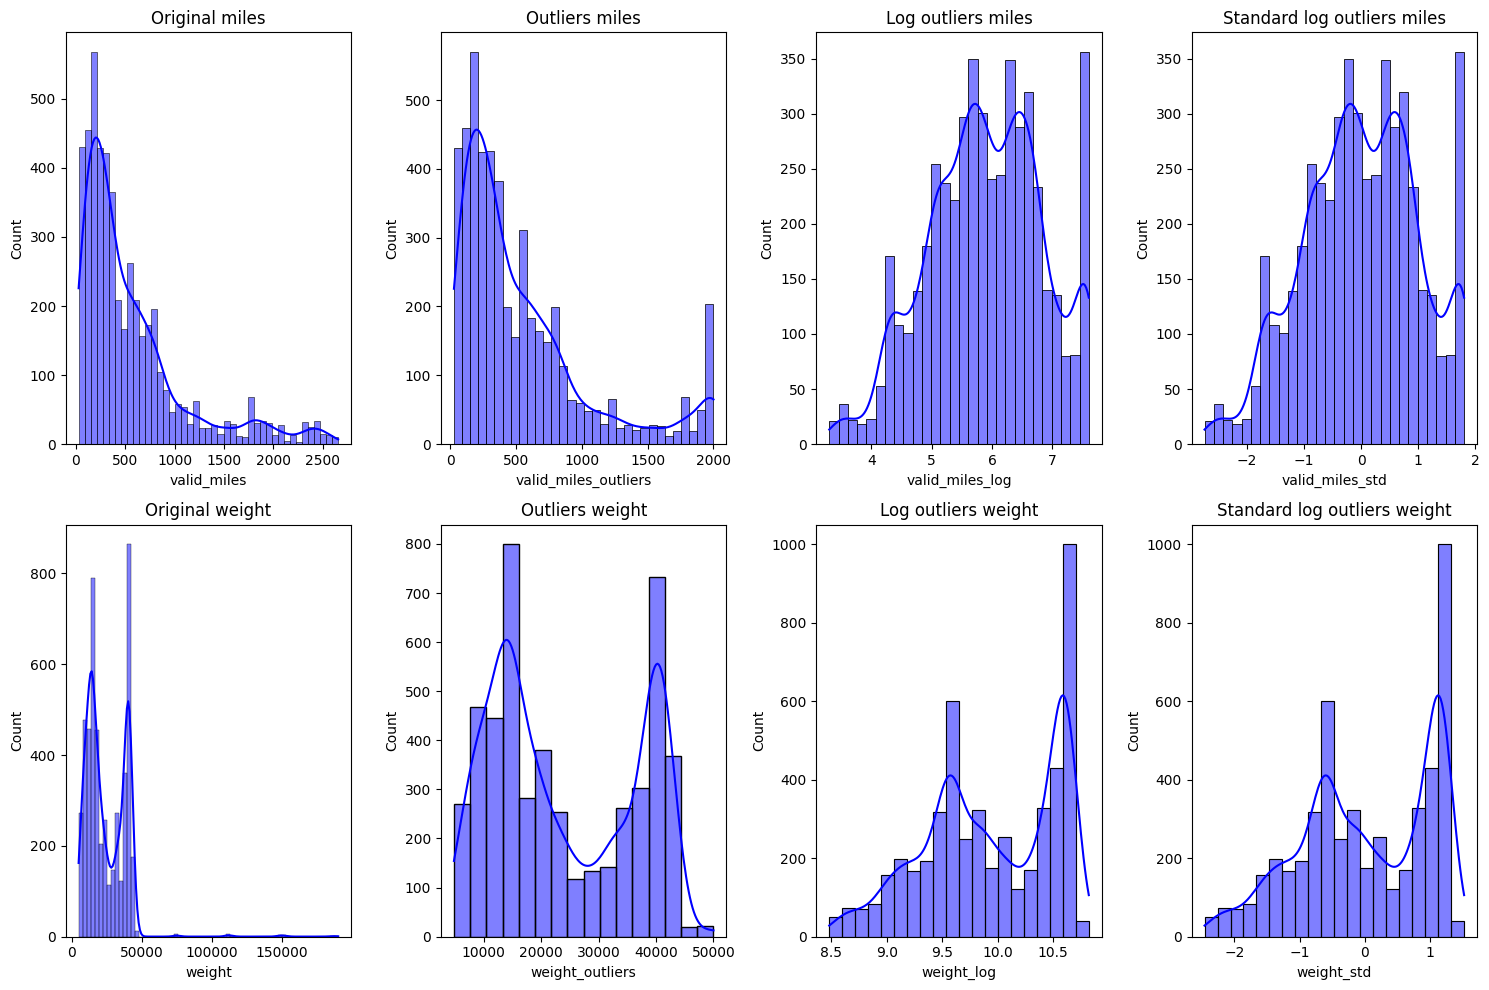

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import holidays

from sklearn.preprocessing import StandardScaler


def prepare_data(df, mapping_origin_kma=None, mapping_destination_kma=None, miles_limit=2000, weight_limit=50000, show_hist=True): # 2000, 50000
    # extract date features
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    df["year"] = df["pickup_date"].dt.year
    df["month"] = df["pickup_date"].dt.month
    df["day"] = df["pickup_date"].dt.day
    df["dayofweek"] = df["pickup_date"].dt.dayofweek
    df["minute"] = df["pickup_date"].dt.minute
    df["dayofyear"] = df["pickup_date"].dt.dayofyear
    df["quarter"] = df["pickup_date"].dt.quarter
    df["week_num"] = df["pickup_date"].dt.isocalendar().week

    # add USA holidays
    usa_holidays = holidays.US()
    df['is_holiday'] = df['pickup_date'].dt.date.apply(lambda x: x in usa_holidays)
    df['is_holiday'] = df['is_holiday'].astype(int)

    # transform date features
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    df["day_sin"] = np.sin(2 * np.pi * df["day"] / 30.42)
    df["day_cos"] = np.cos(2 * np.pi * df["day"] / 30.42)
    df["dayofweek_sin"] = np.sin(2 * np.pi * df["dayofweek"] / 7)
    df["dayofweek_cos"] = np.cos(2 * np.pi * df["dayofweek"] / 7)
    df["minute_sin"] = np.sin(2 * np.pi * df["minute"] / 60)
    df["minute_cos"] = np.cos(2 * np.pi * df["minute"] / 60)
    df["dayofyear_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["dayofyear_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)
    df["quarter_sin"] = np.sin(2 * np.pi * df["quarter"] / 4)
    df["quarter_cos"] = np.cos(2 * np.pi * df["quarter"] / 4)
    df["week_num_sin"] = np.sin(2 * np.pi * df["week_num"] / 52.14)
    df["week_num_cos"] = np.cos(2 * np.pi * df["week_num"] / 52.14)
    
    # valid_miles processing
    df['valid_miles_outliers'] = np.where(df['valid_miles'] > miles_limit, miles_limit, df['valid_miles'])
    df['valid_miles_log'] = np.log(df['valid_miles_outliers'])
    scaler = StandardScaler()
    df[['valid_miles_std']] = scaler.fit_transform(df[['valid_miles_log']])
    
    # weight processing
    df['weight_outliers'] = np.where(df['weight'] > weight_limit, weight_limit, df['weight'])
    df['weight_log'] = np.log(df['weight_outliers'])
    scaler = StandardScaler()
    df[['weight_std']] = scaler.fit_transform(df[['weight_log']])
    # replace NaN to mean weight
    df.loc[df['weight_std'].isna(), "weight_std"] = df['weight_std'].mean()

    # one-hot encoding for transport_type
    df = pd.get_dummies(df, dtype='int', columns=['transport_type'], prefix='transport')

    # label encoding for origin_kma and destination_kma
    if not mapping_origin_kma:
        mapping_origin_kma =  {v:i for i,v in enumerate(df['origin_kma'].unique())}
    df['origin_kma'] = df['origin_kma'].map(mapping_origin_kma)
    if not mapping_destination_kma:
        mapping_destination_kma =  {v:i for i,v in enumerate(df['destination_kma'].unique())}
    df['destination_kma'] = df['destination_kma'].map(mapping_destination_kma)

    # plot histogram
    if show_hist:
        fig, axes = plt.subplots(2, 4, figsize=(15, 10))
        
        sns.histplot(df['valid_miles'], ax=axes[0, 0], color="blue", kde=True)
        axes[0, 0].set_title('Original miles')
        sns.histplot(df['valid_miles_outliers'], ax=axes[0, 1], color="blue", kde=True)
        axes[0, 1].set_title('Outliers miles')
        sns.histplot(df['valid_miles_log'], ax=axes[0, 2], color="blue", kde=True)
        axes[0, 2].set_title('Log outliers miles')
        sns.histplot(df['valid_miles_std'], ax=axes[0, 3], color="blue", kde=True)
        axes[0, 3].set_title('Standard log outliers miles')
        
        sns.histplot(df['weight'], ax=axes[1, 0], color="blue", kde=True)
        axes[1, 0].set_title('Original weight')
        sns.histplot(df['weight_outliers'], ax=axes[1, 1], color="blue", kde=True)
        axes[1, 1].set_title('Outliers weight')
        sns.histplot(df['weight_log'], ax=axes[1, 2], color="blue", kde=True)
        axes[1, 2].set_title('Log outliers weight')
        sns.histplot(df['weight_std'], ax=axes[1, 3], color="blue", kde=True)
        axes[1, 3].set_title('Standard log outliers weight')
        
        plt.tight_layout()
        plt.show()

    # drop not necessary date columns
    drop_columns = [
        'pickup_date', 'month', 'day', 'dayofweek', 'minute', 'dayofyear', 'quarter', 'week_num',\
        'valid_miles', 'valid_miles_outliers', 'valid_miles_log',\
        'weight', 'weight_outliers', 'weight_log'
    ]
    df = df.drop(drop_columns, axis=1)

    return df, mapping_origin_kma, mapping_destination_kma


print("Preparation of weight and distance for train dataset:\n")
train_df_prepare, mapping_origin_kma, mapping_destination_kma = prepare_data(train_df)
print("Preparation of weight and distance for validation dataset:\n")
validation_df_prepare, mapping_origin_kma, mapping_destination_kma = prepare_data(validation_df, mapping_origin_kma, mapping_destination_kma)
print("Preparation of weight and distance for test dataset:\n")
test_df_prepare, mapping_origin_kma, mapping_destination_kma = prepare_data(test_df, mapping_origin_kma, mapping_destination_kma)

In [3]:
X_train, y_train = train_df_prepare.drop('rate', axis=1), train_df_prepare['rate']
X_validation, y_validation = validation_df_prepare.drop('rate', axis=1), validation_df_prepare['rate']
X_test = test_df_prepare

# Linear regression with Ridge regularization

In [4]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, make_scorer

In [5]:
model = Ridge()
param_grid = {'alpha': [x/1000 for x in range(1, 10)]}          #0.009
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv = TimeSeriesSplit(n_splits=5), 
    scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False), 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

ridge_mse_train = mean_squared_error(y_train, y_pred_train)
ridge_r2_train = r2_score(y_train, y_pred_train)
ridge_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

ridge_mse_validation = mean_squared_error(y_validation, y_pred_validation)
ridge_r2_validation = r2_score(y_validation, y_pred_validation)
ridge_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"Best alpha:      {best_alpha} \n{'='*24}")
print(f"Train MSE:       {ridge_mse_train:.2f}")
print(f"Train R2:        {ridge_r2_train:.2f}")
print(f"Train MAPE:      {ridge_mape_train * 100:.2f}%")        #28.81%
print(f"Validation MSE:  {ridge_mse_validation:.2f}")
print(f"Validation R2:   {ridge_r2_validation:.2f}")
print(f"Validation MAPE: {ridge_mape_validation * 100:.2f}%")   #30.42%

Best alpha:      0.009 
Train MSE:       4.63
Train R2:        0.48
Train MAPE:      28.81%
Validation MSE:  7.17
Validation R2:   0.36
Validation MAPE: 30.42%


# Linear regression with Lasso regularization

In [6]:
model = Lasso()
param_grid = {'alpha': [x/100 for x in range(1, 100)]}          #0.03
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv = TimeSeriesSplit(n_splits=5), 
    scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False), 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

lasso_mse_train = mean_squared_error(y_train, y_pred_train)
lasso_r2_train = r2_score(y_train, y_pred_train)
lasso_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

lasso_mse_validation = mean_squared_error(y_validation, y_pred_validation)
lasso_r2_validation = r2_score(y_validation, y_pred_validation)
lasso_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"Best alpha:      {best_alpha} \n{'='*24}")
print(f"Train MSE:       {lasso_mse_train:.2f}")
print(f"Train R2:        {lasso_r2_train:.2f}")
print(f"Train MAPE:      {lasso_mape_train * 100:.2f}%")        #28.73%
print(f"Validation MSE:  {lasso_mse_validation:.2f}")
print(f"Validation R2:   {lasso_r2_validation:.2f}")
print(f"Validation MAPE: {lasso_mape_validation * 100:.2f}%")   #30.06%

Best alpha:      0.03 
Train MSE:       4.67
Train R2:        0.47
Train MAPE:      28.73%
Validation MSE:  7.23
Validation R2:   0.35
Validation MAPE: 30.06%


# Linear regression with Lasso & Ridge regularization

In [7]:
model = ElasticNet(max_iter=5000)
param_grid = {
    'alpha': [0.15, 0.2, 0.25, 0.4, 0.5],                       #0.2
    'l1_ratio': [0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]       #0.1
}
grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv = TimeSeriesSplit(n_splits=5), 
    scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False), 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_alpha = grid_search.best_params_['alpha']
best_l1_ratio = grid_search.best_params_['l1_ratio']

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

elastic_mse_train = mean_squared_error(y_train, y_pred_train)
elastic_r2_train = r2_score(y_train, y_pred_train)
elastic_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

elastic_mse_validation = mean_squared_error(y_validation, y_pred_validation)
elastic_r2_validation = r2_score(y_validation, y_pred_validation)
elastic_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"Best alpha:      {best_alpha}") 
print(f"Best l1_ratio:   {best_l1_ratio} \n{'='*24}")
print(f"Train MSE:       {elastic_mse_train:.2f}")
print(f"Train R2:        {elastic_r2_train:.2f}")
print(f"Train MAPE:      {elastic_mape_train * 100:.2f}%")      #27.81%
print(f"Validation MSE:  {elastic_mse_validation:.2f}")
print(f"Validation R2:   {elastic_r2_validation:.2f}")
print(f"Validation MAPE: {elastic_mape_validation * 100:.2f}%") #28.89%

Best alpha:      0.2
Best l1_ratio:   0.1 
Train MSE:       4.86
Train R2:        0.45
Train MAPE:      27.81%
Validation MSE:  7.35
Validation R2:   0.34
Validation MAPE: 28.89%


# Polynomial regression with Lasso & Ridge regularization

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [9]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('elasticnet', ElasticNet(
        alpha=0.06,                                             #0.06
        l1_ratio=0.3,                                           #0.3
        max_iter=30000
    )
    ) 
])
param_grid = {'poly__degree': [1, 2]}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv = TimeSeriesSplit(n_splits=5), 
    scoring = make_scorer(mean_absolute_percentage_error, greater_is_better=False), 
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_poly_degree = grid_search.best_params_['poly__degree']

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

poly_mse_train = mean_squared_error(y_train, y_pred_train)
poly_r2_train = r2_score(y_train, y_pred_train)
poly_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

poly_mse_validation = mean_squared_error(y_validation, y_pred_validation)
poly_r2_validation = r2_score(y_validation, y_pred_validation)
poly_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"Best poly degree: {best_poly_degree} \n{'='*24}")
print(f"Train MSE:        {poly_mse_train:.2f}")
print(f"Train R2:         {poly_r2_train:.2f}")
print(f"Train MAPE:       {poly_mape_train * 100:.2f}%")        #21.63%
print(f"Validation MSE:   {poly_mse_validation:.2f}")
print(f"Validation R2:    {poly_r2_validation:.2f}")
print(f"Validation MAPE:  {poly_mape_validation * 100:.2f}%")   #24.82%

/home/voodyara/greenscreens/greenscreens_test/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.101e+04, tolerance: 4.648e+01
  model = cd_fast.enet_coordinate_descent(
/home/voodyara/greenscreens/greenscreens_test/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best poly degree: 2 
Train MSE:        3.00
Train R2:         0.66
Train MAPE:       21.63%
Validation MSE:   4.72
Validation R2:    0.58
Validation MAPE:  24.82%


# Random Forest regression

In [10]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [11]:
rf = RandomForestRegressor(random_state=42)

param_search = {
    'n_estimators': [280, 300, 320],                            #280
    'max_depth': [ 28, 32, 36],                                 #32
    'min_samples_split': [3, 4],                                #3
    'min_samples_leaf': [5, 6, 7],                              #6
    'max_features': [0.6, 0.7, 0.8],                            #0.7
    'bootstrap': [True, False],                                 #False
}

random_search = RandomizedSearchCV(
    estimator=rf, 
    param_distributions=param_search, 
    cv=TimeSeriesSplit(n_splits=3), 
    n_jobs=-1, 
    verbose=1,
    n_iter=12,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)
)

start_time = time.time()
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

rf_mse_train = mean_squared_error(y_train, y_pred_train)
rf_r2_train = r2_score(y_train, y_pred_train)
rf_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

rf_mse_validation = mean_squared_error(y_validation, y_pred_validation)
rf_r2_validation = r2_score(y_validation, y_pred_validation)
rf_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"RS RandomForest time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
print(f"Best params:          {best_params} \n{'='*28}")
print(f"Train MSE:            {rf_mse_train:.2f}")
print(f"Train R2:             {rf_r2_train:.2f}")
print(f"Train MAPE:           {rf_mape_train * 100:.2f}%")      #4.35%
print(f"Validation MSE:       {rf_mse_validation:.2f}")
print(f"Validation R2:        {rf_r2_validation:.2f}")
print(f"Validation MAPE:      {rf_mape_validation * 100:.2f}%") #17.85%

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/home/voodyara/greenscreens/greenscreens_test/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RS RandomForest time: 00:32:32
Best params:          {'n_estimators': 280, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 0.7, 'max_depth': 28, 'bootstrap': False} 
Train MSE:            0.58
Train R2:             0.93
Train MAPE:           4.39%
Validation MSE:       2.76
Validation R2:        0.75
Validation MAPE:      17.80%


# LightGBM regression

In [12]:
import time
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [13]:
lgb_reg = lgb.LGBMRegressor(objective='regression', verbosity=-1)

param_search = {
    'n_estimators': [450, 500, 550],                            #500 
    'learning_rate': [0.1],                                     #0.1
    'max_depth': [-1],                                          #-1
    'num_leaves': [63],                                         #63
    'subsample': [1.0],                                         #1.0
    'colsample_bytree': [0.9],                                  #0.9
    'reg_alpha': [0.1],                                         #0.1
    'reg_lambda': [0.1],                                        #0.1
    'min_split_gain': [0.125, 0.15],                            #0.15
    'min_child_samples': [8, 10, 12, 15],                       #15
    'min_gain_to_split': [0.0],                                 #0.0
    'boosting': ['gbdt'],                                       #gbdt
    'data_sample_strategy': ['goss'],                           #goss
    'force_row_wise': [True]                                    #True
} 

random_search = RandomizedSearchCV(
    estimator=lgb_reg,
    param_distributions=param_search,
    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    cv=TimeSeriesSplit(n_splits=3),
    verbose=0,
    n_jobs=-1,
    n_iter=6,
    random_state=42
)

start_time = time.time()
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_validation = best_model.predict(X_validation)

lgb_mse_train = mean_squared_error(y_train, y_pred_train)
lgb_r2_train = r2_score(y_train, y_pred_train)
lgb_mape_train = mean_absolute_percentage_error(y_train, y_pred_train)

lgb_mse_validation = mean_squared_error(y_validation, y_pred_validation)
lgb_r2_validation = r2_score(y_validation, y_pred_validation)
lgb_mape_validation = mean_absolute_percentage_error(y_validation, y_pred_validation)

print(f"RS LightGBM time: {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}")
print(f"Best params:      {best_params} \n{'='*24}")
print(f"Train MSE:        {lgb_mse_train:.2f}")
print(f"Train R2:         {lgb_r2_train:.2f}")
print(f"Train MAPE:       {lgb_mape_train * 100:.2f}%")         #8.54%
print(f"Validation MSE:   {lgb_mse_validation:.2f}")
print(f"Validation R2:    {lgb_r2_validation:.2f}")
print(f"Validation MAPE:  {lgb_mape_validation * 100:.2f}%")    #14.89%

RS LightGBM time: 01:51:49
Best params:      {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 450, 'min_split_gain': 0.125, 'min_gain_to_split': 0.0, 'min_child_samples': 15, 'max_depth': -1, 'learning_rate': 0.1, 'force_row_wise': True, 'data_sample_strategy': 'goss', 'colsample_bytree': 0.9, 'boosting': 'gbdt'} 
Train MSE:        0.57
Train R2:         0.94
Train MAPE:       8.68%
Validation MSE:   2.38
Validation R2:    0.79
Validation MAPE:  14.96%


# Auto ML h2o regression

In [14]:
import time
import h2o
import pandas as pd
import numpy as np
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [15]:
h2o.init(max_mem_size="16G")

run_time_sec = 1200
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_validation, y_validation], axis=1)
train_h2o = h2o.H2OFrame(train_data)
test_h2o = h2o.H2OFrame(test_data)

# Find base models
start_time = time.time()
aml = H2OAutoML(max_runtime_secs=run_time_sec, seed=1, balance_classes=True, stopping_metric="RMSE", exclude_algos=["DeepLearning"])
aml.train(x=X_train.columns.tolist(), y='rate', training_frame=train_h2o)
best_model = aml.leader

# Evaluate the model on the training set
train_predictions = best_model.predict(train_h2o).as_data_frame(use_multi_thread=True)['predict'].values
y_train_np = y_train.values
h2o_mse_train = mean_squared_error(y_train_np, train_predictions)
h2o_r2_train = r2_score(y_train_np, train_predictions)
h2o_mape_train = mean_absolute_percentage_error(y_train_np, train_predictions)

# Evaluate the model on the validation set
test_predictions = best_model.predict(test_h2o).as_data_frame(use_multi_thread=True)['predict'].values
y_validation_np = y_validation.values
h2o_mse_validation = mean_squared_error(y_validation_np, test_predictions)
h2o_r2_validation = r2_score(y_validation_np, test_predictions)
h2o_mape_validation = mean_absolute_percentage_error(y_validation_np, test_predictions)

# Print results
print(f"\nLeaderboard:\n     {aml.leaderboard}")
print(f"\nBest model:\n      {best_model}")
print(f"\nBest parameters:\n {best_model.get_params()}\n")
print(f"CV h2o time:         {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}\n{'='*28}")
print(f"Train MSE:           {h2o_mse_train:.2f}")
print(f"Train R2:            {h2o_r2_train:.2f}")
print(f"Train MAPE:          {h2o_mape_train * 100:.2f}%")
print(f"Validation MSE:      {h2o_mse_validation:.2f}")
print(f"Validation R2:       {h2o_r2_validation:.2f}")
print(f"Validation MAPE:     {h2o_mape_validation * 100:.2f}%")

# Clean up
h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /home/voodyara/greenscreens/greenscreens_test/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvga5o3om
  JVM stdout: /tmp/tmpvga5o3om/h2o_voodyara_started_from_python.out
  JVM stderr: /tmp/tmpvga5o3om/h2o_voodyara_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Warsaw
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_voodyara_p58am9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%

Leaderboard:
     model_id                                                    rmse      mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_4_AutoML_1_20241006_133342     1.02604  1.05275  0.405613  0.092953                    1.05275
StackedEnsemble_BestOfFamily_5_AutoML_1_20241006_133342  1.02798  1.05675 

# Results

In [16]:
def highlight_min_mape(s, color):
    is_min = s == s.min()
    
    return [f'background-color: {color}' if v else '' for v in is_min]

df_results = pd.DataFrame(columns=['train_MSE', 'train_R2', 'train_MAPE_%', 
                                   'validation_MSE', 'validation_R2', 'validation_MAPE_%'])

for prefix in ['ridge', 'lasso', 'elastic', 'poly', 'rf','lgb', 'h2o']:
    df_results.loc[prefix] = {
        'train_MSE': globals()[f'{prefix}_mse_train'], 
        'train_R2': globals()[f'{prefix}_r2_train'], 
        'train_MAPE_%': globals()[f'{prefix}_mape_train']*100, 
        'validation_MSE': globals()[f'{prefix}_mse_validation'], 
        'validation_R2': globals()[f'{prefix}_r2_validation'], 
        'validation_MAPE_%': globals()[f'{prefix}_mape_validation']*100
    }
df_results = df_results.style.apply(highlight_min_mape, color='yellow', subset=['validation_MAPE_%']).\
                              apply(highlight_min_mape, color='orange', subset=['train_MAPE_%'])
df_results

,train_MSE,train_R2,train_MAPE_%,validation_MSE,validation_R2,validation_MAPE_%
ridge,4.630592,0.478307,28.807886,7.171022,0.356022,30.417262
lasso,4.665083,0.474421,28.726994,7.231306,0.350608,30.055708
elastic,4.858767,0.452600,27.806261,7.346864,0.340230,28.890697
poly,3.001425,0.661853,21.626261,4.724700,0.575708,24.820492
rf,0.581876,0.934444,4.386641,2.758161,0.752309,17.803757
lgb,0.570338,0.935744,8.680545,2.376736,0.786562,14.961477
h2o,0.498897,0.943793,5.834281,1.895169,0.829808,16.347062


<p style="font-size:18px;">
Three of the 7 models have MAPEs less than 9% on train dataset, with RandomForest having the best value of 4.68%.<br>
The best MAPE on the validation dataset has LightGBM with 14.96% instead of RandomForest's 17.80%, which means RandomForest is overfitting.<br>
Therefore, the LightGBM model was chosen for predictions on the full (test and validation) dataset, which returned 8.57% MAPE on this data.<br>
To test this model for y_test data, load the missing data and execute the code below.
</p>

# Prediction test with best model

In [17]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import time

In [18]:
X_train_validation = pd.concat([X_train, X_validation], axis=0) 
y_train_validation = pd.concat([y_train, y_validation], axis=0)

In [19]:
best_params = {
    'n_estimators': 500, 
    'learning_rate': 0.1, 
    'max_depth': -1, 
    'num_leaves': 63, 
    'subsample': 1.0, 
    'colsample_bytree': 0.9, 
    'reg_alpha': 0.1, 
    'reg_lambda': 0.1, 
    'min_split_gain': 0.15, 
    'min_child_samples': 15, 
    'min_gain_to_split': 0.0, 
    'boosting_type': 'gbdt', 
    'data_sample_strategy': 'goss', 
    'force_row_wise': True,
    'objective': 'regression',
    'verbosity': -1  
}

start_time = time.time()
lgb_best = lgb.LGBMRegressor(**best_params)
lgb_best.fit(X_train_validation, y_train_validation)

y_pred_train_validation = lgb_best.predict(X_train_validation)
y_pred_test = lgb_best.predict(X_test)

lgb_best_mse_train_validation = mean_squared_error(y_train_validation, y_pred_train_validation)
lgb_best_r2_train_validation = r2_score(y_train_validation, y_pred_train_validation)
lgb_best_mape_train_validation = mean_absolute_percentage_error(y_train_validation, y_pred_train_validation)

# determinate y_test and uncomment this strings for evaluate metrics:
# lgb_best_mse_test = mean_squared_error(y_test, y_pred_test)
# lgb_best_r2_test = r2_score(y_test, y_pred_test)
# lgb_best_mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"Best LightGBM time:      {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}\n{'='*28}")
print(f"Train & Validation MSE:  {lgb_best_mse_train_validation:.2f}")
print(f"Train & Validation R2:   {lgb_best_r2_train_validation:.2f}")
print(f"Train & Validation MAPE: {lgb_best_mape_train_validation * 100:.2f}%")

# determinate y_test and uncomment this strings for print metrics:
# print(f"Test MSE:              {lgb_best_mse_test:.2f}")
# print(f"Test R2:               {lgb_best_r2_test:.2f}")
# print(f"Test MAPE:             {lgb_best_mape_test * 100:.2f}%")

Best LightGBM time:      00:00:05
Train & Validation MSE:  0.55
Train & Validation R2:   0.94
Train & Validation MAPE: 8.57%
